# Assigment 1 - Practical deep learning

**Install PyTorch**

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.6 kB/s 
     |████████████████████████████████| 8.8 MB 39.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.2.0+cu92 which 

# Pre coding

In [ ]:
!pip install tabpy

**Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms
import albumentations as A 
from albumentations.pytorch import ToTensorV2
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import random
import io
import pandas as pd

# Define constant/Hyper parameters

In [ ]:
INPUT_DIR = r'C:\Users\Public\Tests'
NUM_FOLDS = 5
NUM_EPOCHS = 10
BATCH_SIZE = 128
IMAGE_SIZE = 128
SEED=2020
NUM_CLASSES=4
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()
splits=KFold(n_splits=NUM_FOLDS,shuffle=True,random_state=42)
foldperf={}

**Give access to drive to all data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = 'drive/MyDrive/your_project_folder/'  #change direction to project folder

# Set GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('active device is:',device)

active device is: cuda


# Data Exploration

import photo

In [ ]:
# img= cv2.imread("/content/gdrive/MyDrive/Tests/b001.jpg")
def read_and_resize_single_img(filename,nrow=224,ncol=224,channels=3):
    from scipy import misc
    arr = cv2.imread(filename)
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
    arr = cv2.resize(arr,dsize=(nrow,ncol))
    return arr

img= read_and_resize_single_img(r"/content/gdrive/MyDrive/Tests/b001.jpg")
plt.imshow(img)

error: ignored

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Purples")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

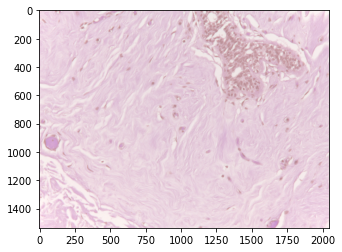

In [ ]:
x= transforms.functional.to_tensor(img)
matplotlib_imshow(x, one_channel=False)


**Blur out a defined half of the image (Left,Right,Up,Down)**

In [ ]:
ind = 1
fig,ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].imshow(np.concatenate([cv2.resize(X[split+ind],(288,288))[:144,:,:],y_large[split+ind,144:,:,:]],axis=0))
ax[0,1].imshow(np.concatenate([cv2.resize(X[split+ind],(288,288))[:,:144,:],y_large[split+ind,:,144:,:]],axis=1))
ax[1,0].imshow(np.concatenate([pred_large[ind,:144,:,:],y_large[split+ind,144:,:,:]],axis=0))
ax[1,1].imshow(np.concatenate([pred_large[ind,:,:144,:],y_large[split+ind,:,144:,:]],axis=1))

**Add total data to train/valid/test Classes**

In [ ]:
train_count = 0
valid_count = 0
test_count = 0
classes =os.listdir(INPUT_DIR + "train")[:NUM_CLASSES];
CLASS_MAP_INT = {classes[i] : i for i in range(len(classes))}

for _class in classes:
    train_count += len(os.listdir(INPUT_DIR + "train/" + _class))
    valid_count += len(os.listdir(INPUT_DIR + "valid/" + _class))
    test_count += len(os.listdir(INPUT_DIR + "test/" + _class))

print(f'Total Classes: {len(classes)}')
print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

# Select images from memory

In [ ]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    for img in os.listdir(INPUT_DIR + "train/" + _class):
        train_imgs.append(INPUT_DIR + "train/" +  _class + "/" + img)
    for img in os.listdir(INPUT_DIR + "valid/" + _class):
        valid_imgs.append(INPUT_DIR + "valid/" + _class + "/" + img)
    for img in os.listdir(INPUT_DIR + "test/" + _class):
        test_imgs.append(INPUT_DIR + "test/"  + _class + "/" + img)

train_imgs_np = np.array(train_imgs)
valid_imgs_np = np.array(valid_imgs)
test_imgs_np =np.array(test_imgs)

# Building the DataSet

In [ ]:
class SomeDataset(Dataset):
    def __init__(self,data_np,transforms=None):
        self.data_np = data_np
        self.transforms = transforms
        
    def __len__(self):
        return self.data_np.shape[0]
    
    def __getitem__(self,idx):
        img_path = self.data_np[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label = img_path.split("/")[-2]
        label = CLASS_MAP_INT[label]
        if not self.transforms is None:
            transformed = self.transforms(image=img)
            img = transformed['image']
        return img, label

# Set transforamtions

In [ ]:
transforms_train = A.Compose([A.Transpose(),A.Resize(height=IMAGE_SIZE,width=IMAGE_SIZE,p=1.0),A.Flip(),A.Normalize(),ToTensorV2(),])
transforms_valid = A.Compose([A.Resize(height=IMAGE_SIZE,width=IMAGE_SIZE,p=1.0),A.Normalize(),ToTensorV2()])

# Build DataSet

In [ ]:
train_dataset = SomeDataset(train_imgs_np,transforms_train) # (image[1,28,28],target)
test_dataset  = SomeDataset(test_imgs_np,transforms_train)# (image[1,28,28],target)
valid_dataset = SomeDataset(valid_imgs_np,transforms_valid)
dataset = ConcatDataset([train_dataset, valid_dataset])

# Build someModel

In [ ]:
from keras.layers import *
from keras.models import Model

**Layers**

In [ ]:
inp = Input(shape=(224,224,3))
x= Conv2D(64,3,activation='relu', strides=1)(inp) # Block 1
x= Conv2D(64,3,activation='relu')(x) # Block 1
x=MaxPooling2D()(x)

x= Conv2D(128,3,activation='relu')(x) # Block 2
x= Conv2D(128,3,activation='relu')(x) # Block 2
x=MaxPooling2D()(x)

x= Conv2D(256,3,activation='relu')(x) # Block 3
x= Conv2D(256,3,activation='relu')(x) # Block 3
x= Conv2D(256,3,activation='relu')(x) # Block 3
x=MaxPooling2D()(x)

x= Conv2D(512,3,activation='relu')(x) # Block 4
x= Conv2D(512,3,activation='relu')(x) # Block 4
x= Conv2D(512,3,activation='relu')(x) # Block 4
x=MaxPooling2D()(x)

x= Conv2D(512,3,activation='relu')(x) # Block 5
x= Conv2D(512,3,activation='relu')(x) # Block 5
x= Conv2D(512,3,activation='relu')(x) # Block 5
x=MaxPooling2D()(x)

x=Flatten()(x)
x=Dense(4096,activation='relu')(x) # Fully connected
x=Dense(4096,activation='relu')(x) # Fully connected
x=Dense(1000,activation='softmax')(x) # Fully connected

model=Model(inp,x)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_52 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 conv2d_53 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_55 (Conv2D)          (None, 106, 106, 128)     147584    
                                                           